In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from time import sleep

In [3]:
from dechorate import constants
from dechorate.dataset import DechorateDataset, SyntheticDataset
from dechorate.utils.file_utils import save_to_pickle, load_from_pickle, save_to_matlab
from dechorate.utils.dsp_utils import normalize, envelope

In [4]:
data_dir = '../data/'
dataset_dir = data_dir + 'dECHORATE/'
path_to_processed = data_dir + 'processed/'
path_to_note_csv = dataset_dir + 'annotations/dECHORATE_database.csv'
path_to_after_calibration = path_to_processed + \
    'post2_calibration/calib_output_mics_srcs_pos.pkl'

note_dict = load_from_pickle(path_to_after_calibration)
dset = DechorateDataset(path_to_processed, path_to_note_csv)
sdset = SyntheticDataset()


datasets = constants['datasets']
c = constants['speed_of_sound']
Fs = constants['Fs']
recording_offset = constants['recording_offset']
L = constants['rir_length']
datasets

['000000',
 '010000',
 '011000',
 '011100',
 '011110',
 '011111',
 '001000',
 '000100',
 '000010',
 '000001']

In [5]:
I = 30
J = 9
D = len(datasets)

## Extraction of Real and Sythetic RIRs

In [6]:
rirs_real = np.zeros([L, I, J, D])
rirs_synt = np.zeros([L, I, J, D])
mics = np.zeros([3, I])
srcs = np.zeros([3, J])


for d in tqdm(range(D), desc='Loop datasets'):
    for i in tqdm(range(I), desc='Lood mic', leave=False):
        for j in range(J):

            dataset_id = datasets[d]
            
            # get rir from the recondings
            dset.set_dataset(dataset_id)
            dset.set_entry(i, j)
            mic, src = dset.get_mic_and_src_pos()
            mics[:, i] = mic
            srcs[:, j] = src
            _, rrir = dset.get_rir()


            # get synthetic rir
            sdset = SyntheticDataset()
            sdset.set_room_size(constants['room_size'])
            sdset.set_dataset(dataset_id, absb=0.85, refl=0.15)
            sdset.set_c(c)
            sdset.set_k_order(17)
            sdset.set_mic(mics[0, i], mics[1, i], mics[2, i])
            sdset.set_src(srcs[0, j], srcs[1, j], srcs[2, j])
            _, srir = sdset.get_rir()
            Ls = len(srir)


            # measure after calibration
            rirs_real[:, i, j, d] = rrir[:L]
            rirs_synt[:Ls, i, j, d] = srir[:Ls]

print('done with the extraction')


done with the extraction


## RIR Segmentation with C-DYSPA

well lets see

In [7]:
import peakutils as pk
from dechorate.externals.cdypsa import Segmentation
# in:
# * RIRs are impulse responses recorded using a microphone array
#   (NxM matix, where N is the number of samples, and M the number of microphones) 
# * 'fs' is a scalar, corresponding to the sample frequency of RIRs. 
# *  groupdelay_threshold sets the threshold at which the
#    slope of the group delay zero crossing is considered to be a reflection e.g -0.05 
# *  'UCA_radius' is a vector containing the radius of the microphone array, 
#     e.g. if the double concentric UCA is
#     used, '[0.083 0.104]'. 
# * 'use_LPC' set to 1 enables the LPC filter inside DYPSA
# * n_discrete sets the number of early reflections returned (not including
#   direct sound)
# * discrete_mode sets the behaviour to return:
#   'first': the first n_discrete reflections
#   'strongest': the strongest n_discrete reflections
# * late_mode sets the behaviour of the late estimation:
#   'data': uses the mean perceptual mixing time based over all RIR chans
#   'model': uses the perceptual mixing time based on the given room
#           dimensions
# * roomDims gives the ground truth room dimensions [l,w,h] or [] if not
#    used

[[ 185]
 [ 365]
 [ 443]
 [ 501]
 [ 603]
 [ 853]
 [ 974]
 [1224]
 [1462]
 [1631]
 [1782]
 [2009]
 [2145]
 [2272]]
[ 185  365  443  501  603  853  974 1224 1462 1631 1782 2009 2145 2272]


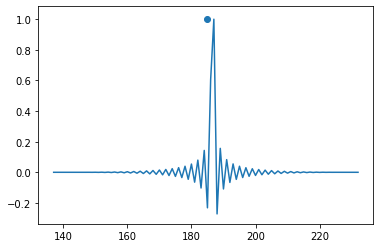

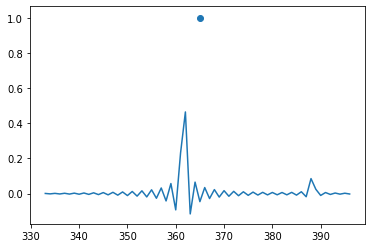

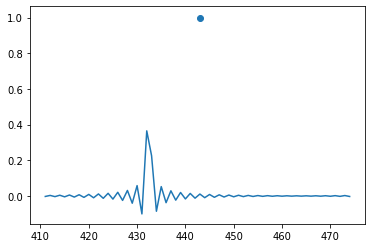

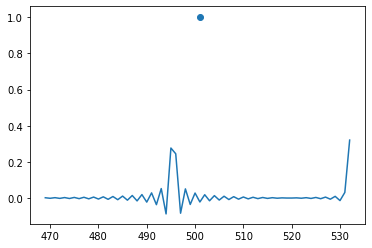

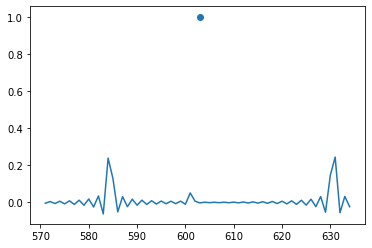

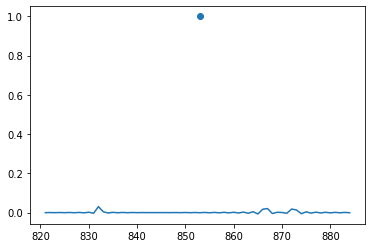

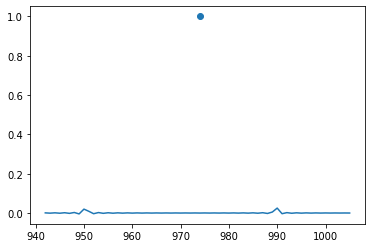

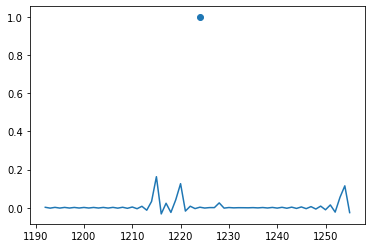

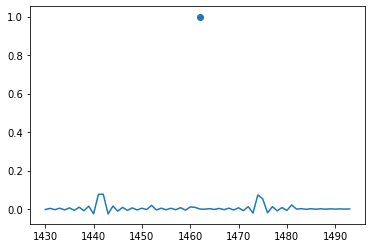

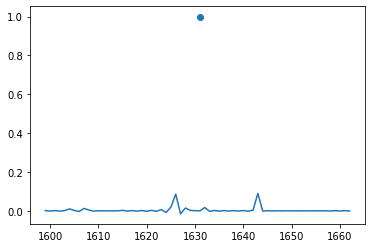

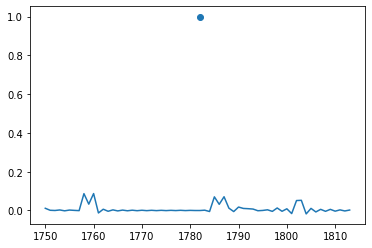

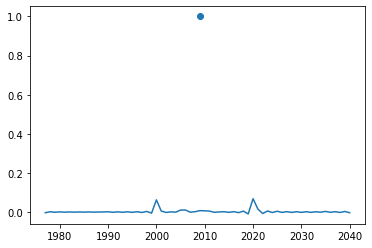

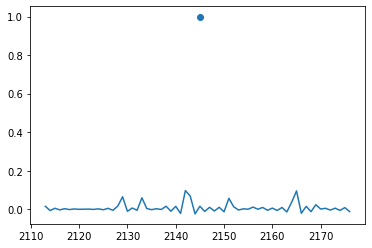

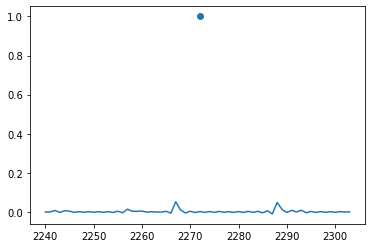

ZeroDivisionError: division by zero

In [19]:
# max_duration = int(0.05 * Fs)
# groupdelay_threshold = -0.1#3.5e-3
# use_LPC = 1
# discrete_mode =  'first'
# n_discrete = 13
# nPeaks = n_discrete + 1
# # Window length for segmenting direct sound and early reflections
# hamm_lengths = [32]*(n_discrete+1)
# hamm_lengths[0] = 0.001 * Fs
# hamm_lengths = np.int_(hamm_lengths)

# counter = 0
# K = nPeaks
# toa = np.zeros((K, J))
# for j in range(J):
#     for i in range(I):

#         rrir = normalize(rirs_real[:max_duration, i, j, 5])
#         srir = normalize(rirs_synt[:max_duration, i, j, 5])
#         # rir normalazation
#         rrir = np.abs(rrir) / np.max(np.abs(rrir))

#         # rir clustering
#         sg = Segmentation(
#             RIRs=srir[:, None], fs=Fs,
#             groupdelay_threshold=groupdelay_threshold,
#             use_LPC=use_LPC, discrete_mode=discrete_mode,
#             nPeaks=nPeaks, hamm_lengths=hamm_lengths)

#         sg.segmentation()
#         toa = sg.TOAs_sample_single_mic
#         print(toa)

#         for k in range(K):
#             if k == 0: # direct path
#                 supp, dp = sg.segments['Direct_sound']
#                 plt.plot(supp, dp)
#                 plt.scatter(toa[0], 1)
#                 plt.show()
#             else: # reflection
#                 supp, dp = sg.segments['Reflection' + str(k)]
#                 plt.plot(supp, dp)
#                 plt.scatter(toa[k], 1)
#                 plt.show()

#         1/0